In [74]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from pathlib import Path
import seaborn as sns 

sns.set_style('darkgrid',)
mpl.rcParams['figure.dpi']= 150

## How do the somatic variants in the FFPE samples compare to the frozen sample
> Using [RTG-tools](https://github.com/RealTimeGenomics/rtg-tools) to compare VCF files accurately

## Allele frequencies >= 0.1

In [13]:
%%bash

lst='FFPE_AIO_3_A1 FFPE_AIO_3_A2 FFPE_AIO_3_A3 FFPE_AIO_3_A4 FFPE_AIO_3_B1 FFPE_AIO_3_B2 FFPE_AIO_3_C1 FFPE_AIO_3_C2 FFPE_AIO_3_S FFPE_AIO_100_S'

for i in $lst; do
    ffpe_path=/Users/DanielaNachmanson/XTHS-analysis/data/vcf_AIO/FF_vs_FFPE_AIO_Intersect/${i}-ensemble.region.gmfilter.dp_qualfilter.vcf.gz
    frfz_path=/Users/DanielaNachmanson/XTHS-analysis/data/vcf_AIO/FF_vs_FFPE_AIO_Intersect/FRFZ-ensemble.region.gmfilter.dp_qualfilter.vcf.gz
    
    java -jar ~/XTHS-analysis/code/rtg-tools/dist/rtg-tools-3.10-5604f7a1/RTG.jar vcfeval -b ${frfz_path} -c ${ffpe_path} \
        -t /Users/DanielaNachmanson/XTHS-analysis/data/genomes/hg19_sdf -o /Users/DanielaNachmanson/XTHS-analysis/data/vcf_eval_AIO_myFZ/${i}.qual \
        --vcf-score-field=QUAL --squash-ploidy --decompose
    
    java -jar ~/XTHS-analysis/code/rtg-tools/dist/rtg-tools-3.10-5604f7a1/RTG.jar vcfeval -b ${frfz_path} -c ${ffpe_path} \
        -t /Users/DanielaNachmanson/XTHS-analysis/data/genomes/hg19_sdf -o /Users/DanielaNachmanson/XTHS-analysis/data/vcf_eval_AIO_myFZ/${i}.af \
        --vcf-score-field=AF --squash-ploidy --decompose
    
    java -jar ~/XTHS-analysis/code/rtg-tools/dist/rtg-tools-3.10-5604f7a1/RTG.jar vcfeval -b ${frfz_path} -c ${ffpe_path} \
        -t /Users/DanielaNachmanson/XTHS-analysis/data/genomes/hg19_sdf -o /Users/DanielaNachmanson/XTHS-analysis/data/vcf_eval_AIO_myFZ/${i}.dp \
        --vcf-score-field=DP --squash-ploidy --decompose
    
done

Threshold  True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  Sensitivity  F-measure
----------------------------------------------------------------------------------------------------
   52.000                 85             85          8         54     0.9140       0.6115     0.7328
     None                 85             85          8         54     0.9140       0.6115     0.7328

Threshold  True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  Sensitivity  F-measure
----------------------------------------------------------------------------------------------------
    0.273                 84             84          3         55     0.9655       0.6043     0.7434
     None                 85             85          8         54     0.9140       0.6115     0.7328

Threshold  True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  Sensitivity  F-measure
-----------------------------------------------------------------------------------------

Reference sequence chr6 is used in baseline but not in calls.
Reference sequence chrX is used in calls but not in baseline.
Reference sequence chr14 is used in baseline but not in calls.
Reference sequence chr15 is used in baseline but not in calls.
Reference sequence chr20 is used in baseline but not in calls.
Reference sequence chr21 is used in baseline but not in calls.
Reference sequence chr6 is used in baseline but not in calls.
Reference sequence chrX is used in calls but not in baseline.
Reference sequence chr14 is used in baseline but not in calls.
Reference sequence chr15 is used in baseline but not in calls.
Reference sequence chr20 is used in baseline but not in calls.
Reference sequence chr21 is used in baseline but not in calls.
Reference sequence chr6 is used in baseline but not in calls.
Reference sequence chrX is used in calls but not in baseline.
Reference sequence chr14 is used in baseline but not in calls.
Reference sequence chr15 is used in baseline but not in calls

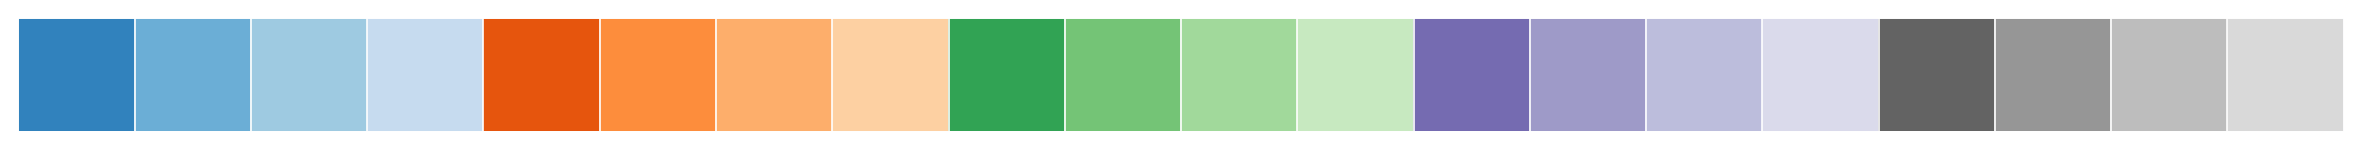

In [75]:
color_scale = sns.color_palette('tab20c').as_hex()
sns.palplot(color_scale)

/Users/DanielaNachmanson/conda/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/DanielaNachmanson/conda/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/DanielaNachmanson/conda/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


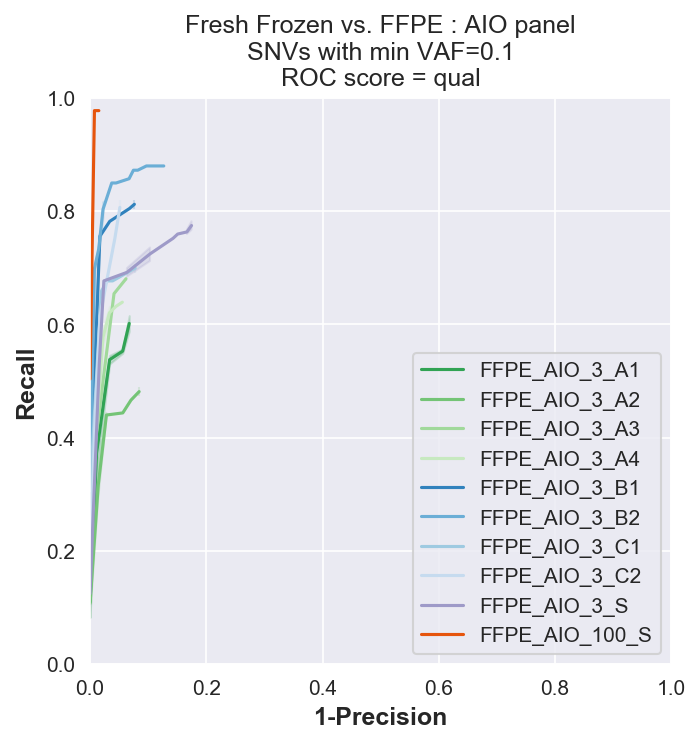

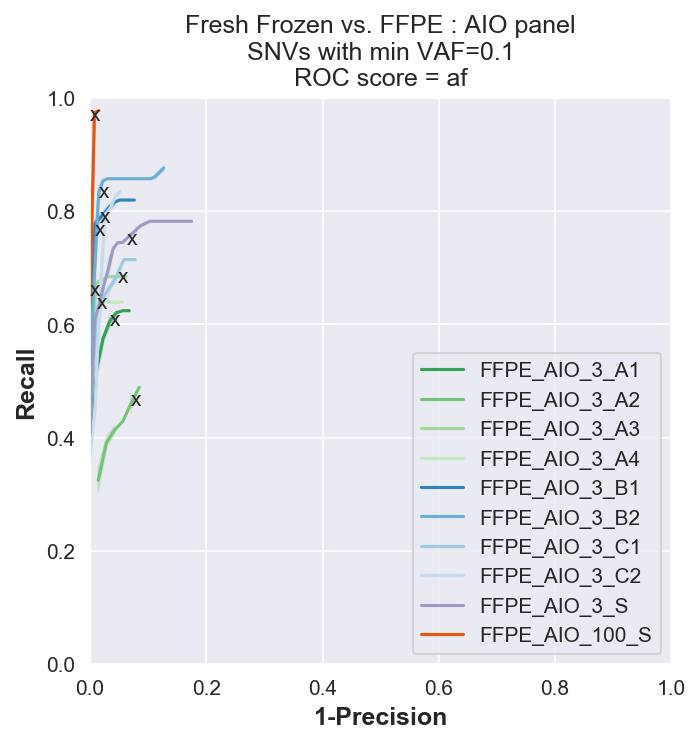

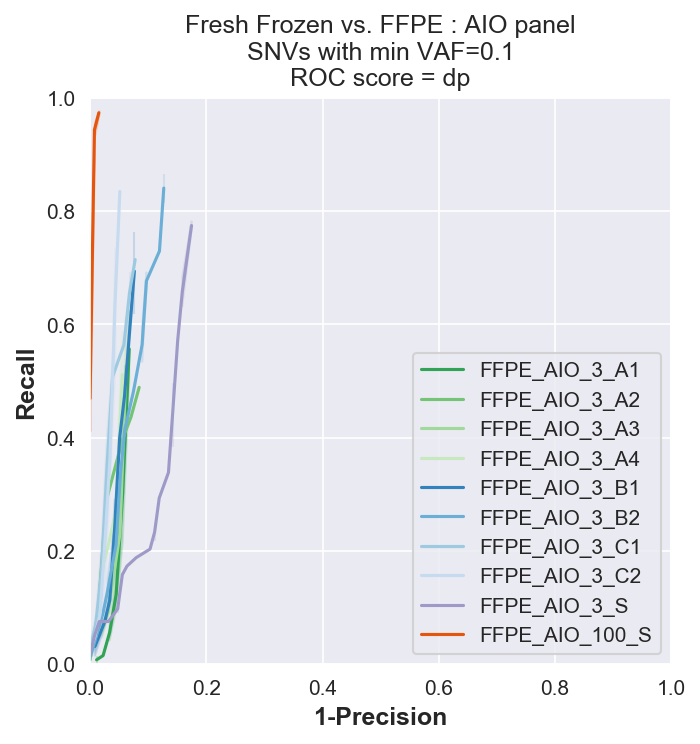

In [76]:
samples = ['FFPE_AIO_3_A1',
           'FFPE_AIO_3_A2',
           'FFPE_AIO_3_A3',
           'FFPE_AIO_3_A4',
           'FFPE_AIO_3_B1',
           'FFPE_AIO_3_B2',
           'FFPE_AIO_3_C1',
           'FFPE_AIO_3_C2',
           'FFPE_AIO_3_S',
           'FFPE_AIO_100_S']

colors= dict(zip(samples,color_scale[8:12] + color_scale[:4] +  [color_scale[13]] + [color_scale[4]]))

for score in ['qual','af', 'dp']:

    fig = plt.figure(figsize=(5,5))
    ax_snp = fig.add_subplot(1, 1, 1)
    
    below_af_thresh = [] # Will contain coordinates of last point with AF >=0.2
    
    for sample in samples:
    
        filename = '../../data/vcf_eval_AIO_myFZ/{}.{}/snp_roc.tsv.gz'.format(sample, score)
        path = Path(filename)

        snp_df = pd.read_table(filename,skiprows=6)

        total_variants_ffpe_snv = max(snp_df['false_positives']) + max(snp_df['true_positives_call'])
        total_variants_frozen_snv = max(snp_df['true_positives_baseline'])/max(snp_df['sensitivity'])
        snp_df['fp_rate'] =snp_df['false_positives']/total_variants_ffpe_snv
        snp_df['tp_rate_ffpe'] = snp_df['true_positives_call']/total_variants_ffpe_snv
        snp_df['tp_rate_frozen'] = snp_df['true_positives_call']/total_variants_frozen_snv

        truth_set = 'tp_rate_frozen'

        if score == 'af':
            t = snp_df[snp_df['#score'] >= 0.3]
            last_score = t.index[-1]
            if sample == 'FFPE_AIO_3_A2':
                last_score = t.index[-2]
            below_af_thresh.append((t['fp_rate'][last_score],t[truth_set][last_score]))
            
        sns.lineplot(snp_df['fp_rate'],
                     snp_df[truth_set],
                     label=sample,
                     ax=ax_snp,
                     color=colors[sample])

    snp_total_true_variants = (max(snp_df['true_positives_call']))/max(snp_df['sensitivity'])
    ax_snp.set_ylim(0,1)
    ax_snp.set_xlim(0,1)
    ax_snp.set_title('Fresh Frozen vs. FFPE : AIO panel\nSNVs with min VAF=0.1\nROC score = {}'.format(score))
    ax_snp.set_ylabel('Recall',fontweight='bold',fontsize=12)
    ax_snp.set_xlabel('1-Precision',fontweight='bold',fontsize=12)
    
    if score == 'af':
        for point in below_af_thresh:
            ax_snp.text(point[0], point[1], 'x',verticalalignment='center')
    
    ax_snp.legend( loc='lower right', ncol=1)
    fig.show()

## Allele frequencies >= 0.2

In [15]:
%%bash

lst='FFPE_AIO_3_A1 FFPE_AIO_3_A2 FFPE_AIO_3_A3 FFPE_AIO_3_A4 FFPE_AIO_3_B1 FFPE_AIO_3_B2 FFPE_AIO_3_C1 FFPE_AIO_3_C2 FFPE_AIO_3_S FFPE_AIO_100_S'

for i in $lst; do
    ffpe_path=/Users/DanielaNachmanson/XTHS-analysis/data/vcf_AIO/FF_vs_FFPE_AIO_Intersect/${i}-ensemble.region.gmfilter.dp_qualfilter.0.2.vcf.gz
    frfz_path=/Users/DanielaNachmanson/XTHS-analysis/data/vcf_AIO/FF_vs_FFPE_AIO_Intersect/FRFZ-ensemble.region.gmfilter.dp_qualfilter.0.2.vcf.gz
    
    java -jar ~/XTHS-analysis/code/rtg-tools/dist/rtg-tools-3.10-5604f7a1/RTG.jar vcfeval -b ${frfz_path} -c ${ffpe_path} \
        -t /Users/DanielaNachmanson/XTHS-analysis/data/genomes/hg19_sdf -o /Users/DanielaNachmanson/XTHS-analysis/data/vcf_eval_AIO_myFZ/${i}.qual.0.2 \
        --vcf-score-field=QUAL --squash-ploidy --decompose

done

Threshold  True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  Sensitivity  F-measure
----------------------------------------------------------------------------------------------------
   52.000                 85             85          5         51     0.9444       0.6250     0.7522
     None                 85             85          5         51     0.9444       0.6250     0.7522

Threshold  True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  Sensitivity  F-measure
----------------------------------------------------------------------------------------------------
   63.000                 67             67          5         69     0.9306       0.4926     0.6442
     None                 67             67          5         69     0.9306       0.4926     0.6442

Threshold  True-pos-baseline  True-pos-call  False-pos  False-neg  Precision  Sensitivity  F-measure
-----------------------------------------------------------------------------------------

Reference sequence chr6 is used in baseline but not in calls.
Reference sequence chrX is used in calls but not in baseline.
Reference sequence chr14 is used in baseline but not in calls.
Reference sequence chr15 is used in baseline but not in calls.
Reference sequence chr20 is used in baseline but not in calls.
Reference sequence chr21 is used in baseline but not in calls.
Reference sequence chr6 is used in baseline but not in calls.
Reference sequence chr14 is used in baseline but not in calls.
Reference sequence chr15 is used in baseline but not in calls.
Reference sequence chr21 is used in baseline but not in calls.
Reference sequence chr6 is used in baseline but not in calls.
Reference sequence chr15 is used in baseline but not in calls.
Reference sequence chrX is used in calls but not in baseline.
Reference sequence chr14 is used in baseline but not in calls.
Reference sequence chr22 is used in baseline but not in calls.
Reference sequence chr21 is used in baseline but not in call

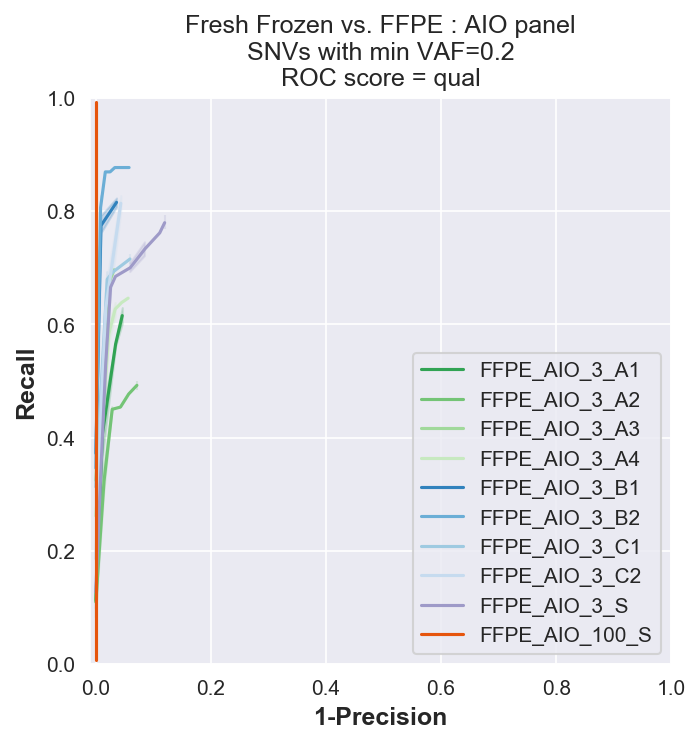

In [78]:
samples = ['FFPE_AIO_3_A1',
           'FFPE_AIO_3_A2',
           'FFPE_AIO_3_A3',
           'FFPE_AIO_3_A4',
           'FFPE_AIO_3_B1',
           'FFPE_AIO_3_B2',
           'FFPE_AIO_3_C1',
           'FFPE_AIO_3_C2',
           'FFPE_AIO_3_S',
           'FFPE_AIO_100_S']

colors= dict(zip(samples,color_scale[8:12] + color_scale[:4] +  [color_scale[13]] + [color_scale[4]]))

fig = plt.figure(figsize=(5,5))
ax_snp = fig.add_subplot(1, 1, 1)

for sample in samples:

    filename = '../../data/vcf_eval_AIO_myFZ/{}.{}.0.2/snp_roc.tsv.gz'.format(sample, 'qual')
    path = Path(filename)

    snp_df = pd.read_table(filename,skiprows=6)

    total_variants_ffpe_snv = max(snp_df['false_positives']) + max(snp_df['true_positives_call'])
    total_variants_frozen_snv = max(snp_df['true_positives_baseline'])/max(snp_df['sensitivity'])
    snp_df['fp_rate'] =snp_df['false_positives']/total_variants_ffpe_snv
    snp_df['tp_rate_frozen'] = snp_df['true_positives_call']/total_variants_frozen_snv

    truth_set = 'tp_rate_frozen'
    
    if sample == 'FFPE_AIO_100_S':
        est = None
    else:
        est = 'mean'
    sns.lineplot(snp_df['fp_rate'],
                 snp_df[truth_set],
                 label=sample,
                 ax=ax_snp,
                 color=colors[sample],
                 estimator=est)

    snp_total_true_variants = (max(snp_df['true_positives_call']))/max(snp_df['sensitivity'])
    ax_snp.set_ylim(0,1)
    ax_snp.set_xlim(-0.01,1)
    ax_snp.set_title('Fresh Frozen vs. FFPE : AIO panel\nSNVs with min VAF=0.2\nROC score = {}'.format('qual'))
    ax_snp.set_ylabel('Recall',fontweight='bold',fontsize=12)
    ax_snp.set_xlabel('1-Precision',fontweight='bold',fontsize=12)
    
    ax_snp.legend( loc='lower right', ncol=1)
plt.show()